In [135]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression

## Load in Data

In [136]:
# Load tensors from the file
loaded_data = torch.load('features/data_tensors_extra.pth')
X_bond = loaded_data['X']
X_bond = [i.numpy() for i in X_bond]
X_struc = loaded_data['X_struc'].numpy()
y = np.ravel(loaded_data['y'].numpy())

# Load Preprocessing Parameters
X_mean = loaded_data['X_mean'].numpy()
X_std = loaded_data['X_std'].numpy()
X_struc_mean = loaded_data['X_struc_mean'].numpy()
X_struc_std = loaded_data['X_struc_std'].numpy()
y_mean = loaded_data['y_mean'].numpy()
y_std = loaded_data['y_std'].numpy()
feature_labels = loaded_data['feature_labels']
data_labels = loaded_data['sample_class_labels']
print("Number labels:", len(y))

num_bonds = 0
for x in X_bond:
    num_bonds += len(x)
print("Total Number of Bonds: ", num_bonds)

Number labels: 1074
Total Number of Bonds:  2698482


## Flatten Bond Sequences

In [137]:
# Transform sequence of data in X to a constant length array
data_len = len(y)

# Use mean, max, min, std
X = []
combined_feat_labels = []
for i in range(data_len):
    feat = np.concatenate((np.mean(X_bond[i], axis=0), np.max(X_bond[i], axis=0), np.min(X_bond[i], axis=0), np.std(X_bond[i], axis=0)))
    combined_feat_labels = [i+"_mean" for i in feature_labels[0]]+[i+"_max" for i in feature_labels[0]]+[i+"_min" for i in feature_labels[0]]+[i+"_std" for i in feature_labels[0]]
    feat = np.concatenate((feat, X_struc[i]))
    combined_feat_labels += feature_labels[1]  # add struc feat labels
    X.append(feat)
X = np.array(X)

## Spearman Correlation Matrix

In [138]:
from scipy.stats import spearmanr
feat_labs = feature_labels[1]+["TEC"]
# Correlation matrix of Structural Features
spearman_struc = spearmanr(np.column_stack((X_struc,y.reshape(-1,1)))).correlation
spearman_struc = np.nan_to_num(spearman_struc)
print(dict(zip(feat_labs,[int(100*i)/100 for i in spearman_struc[-1]])))

## Correlation matrix for Mean Bond Features
feat_labs = feature_labels[0]+["TEC"]
spearman_bond = spearmanr(np.column_stack((X[:,0:len(X_bond[0][0])],y.reshape(-1,1)))).correlation  # only select mean
print(dict(zip(feat_labs,[int(100*i)/100 for i in spearman_bond[-1]])))
"""
fig, ax = plt.subplots()
im = ax.imshow(spearman_bond, aspect='auto')
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(feat_labs)), labels=feat_labs)
ax.set_yticks(np.arange(len(feat_labs)), labels=feat_labs)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
for i in range(len(feat_labs)):
    for j in range(len(feat_labs)):
        text = ax.text(j, i, np.round(100*spearman_bond[i, j])/100,
                       ha="center", va="center", color="w")
ax.set_title("Spearman Matrix for Mean Bond Features")
plt.savefig("figs/"+"spearman_bond.png")
plt.show()
"""

{'structural complexity per atom': 0.1, 'structural complexity per cell': 0.08, 'jml_pack_frac': -0.07, 'jml_vpa': 0.05, 'jml_density': -0.07, 'jml_log_vpa': 0.2, 'max packing efficiency': 0.22, 'density': -0.09, 'vpa': 0.12, 'packing fraction': 0.22, 'number of elements': 0.12, 'entropy of mixing': 0.13, 'C1 polyhedra frac': 0.08, 'C2 polyhedra frac': -0.01, 'C3 polyhedra frac': 0.0, 'C4 polyhedra frac': 0.0, 'C5 polyhedra frac': 0.0, 'C6 polyhedra frac': -0.03, 'C7 polyhedra frac': -0.05, 'C8 polyhedra frac': 0.17, 'Low DOF polyhedra frac': -0.1, 'High DOF polyhedra frac': 0.1, 'temperature': 0.1, 'dil_data': 0.16, 'xrd_data': -0.16, 'TEC': 1.0}
{'site Number_atom1': 0.0, 'site Number_atom2': -0.1, 'site AtomicWeight_diff': -0.01, 'site AtomicWeight_atom1': 0.0, 'site AtomicWeight_atom2': 0.05, 'site Electronegativity_diff': -0.1, 'site Electronegativity_atom1': -0.06, 'site Electronegativity_atom2': -0.05, 'site CovalentRadius_atom1': 0.06, 'site CovalentRadius_atom2': -0.04, 'AGNI 

/share/software/user/open/py-numpy/1.20.3_py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/share/software/user/open/py-numpy/1.20.3_py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


'\nfig, ax = plt.subplots()\nim = ax.imshow(spearman_bond, aspect=\'auto\')\n# Show all ticks and label them with the respective list entries\nax.set_xticks(np.arange(len(feat_labs)), labels=feat_labs)\nax.set_yticks(np.arange(len(feat_labs)), labels=feat_labs)\nplt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")\n# Loop over data dimensions and create text annotations.\nfor i in range(len(feat_labs)):\n    for j in range(len(feat_labs)):\n        text = ax.text(j, i, np.round(100*spearman_bond[i, j])/100,\n                       ha="center", va="center", color="w")\nax.set_title("Spearman Matrix for Mean Bond Features")\nplt.savefig("figs/"+"spearman_bond.png")\nplt.show()\n'

## Define ModelTrainer Object

In [139]:
class ModelTrainer:
    models = []
    
    def __init__(self, x_data, y_data, data_labels, y_std = 1, y_mean = 0):
        self.x = x_data
        self.y = y_data
        self.data_labels = data_labels
        self.y_std = y_std
        self.y_mean = y_mean
        self.only_dil = False
        self.only_xrd = False
        self.n_folds = 5
        
    def add_models(self, models):
        if type(models) == list:
            self.models += models
        else:
            self.models.append(models) # if only 1 model given
    
    def clear_models(self):
        self.models = []
    
    def y_transform(self, y):
        return list(y*self.y_std + self.y_mean)
 
    def k_folds_generator(self):
        # selected_idxs: the subset of all data chosen for this test
        # Set up Cross Validation with K-Folds
        k_folds = KFold(n_splits=self.n_folds, shuffle=True) # random_state=42
        self.train_idxs = []
        self.test_idxs = []
        x_idxs = np.arange(len(self.selected_idxs))  # create a list of indexes of length selected_idxs
        for train_index, test_index in k_folds.split(x_idxs):
            self.train_idxs.append(self.selected_idxs[train_index])
            self.test_idxs.append(self.selected_idxs[test_index])
        
    def index_selector(self, selected_types, top_n_selections, segmented_type, top_n_segments, only_dil=False, only_xrd=False):
        # selected_types: [a list of strings] to select of data, ex: ["class", "system"]
        # top_n_selections: [a list of idex lists] to select only some of the 
        # segmented_type: [string] segment the selected data by this class for individual scoring and plotting
        # top_n_segments: [list of indexes] label the top n segments then lump the rest into 'etc'
        self.only_dil = only_dil
        self.only_xrd = only_xrd
        
        # Define Data Selections
        selected_idx_sets = []
        self.selected_labels = []  # labels for data subsets
        # First, select by xrd or dil
        if self.only_dil:
            self.selected_labels.append("Dilatometer Data")
            all_idxs = []
            for i in range(len(self.x)):
                if self.x[i][-2] == 1:
                    all_idxs.append(i)
            selected_idx_sets.append(set(all_idxs))
        elif self.only_xrd:
            self.selected_labels.append("XRD Data")
            all_idxs = []
            for i in range(len(self.x)):
                if self.x[i][-1] == 1:
                    all_idxs.append(i)
            selected_idx_sets.append(set(all_idxs))
        
        # Now select by other parameters
        for i in range(len(selected_types)):
            all_idxs = []
            label_dict, ranked_label = self.label_to_indexes(selected_types[i])
            for k in top_n_selections[i]: # combine all idxs from top n classes
                all_idxs += label_dict[ranked_label[k]]
                self.selected_labels.append(ranked_label[k])
            selected_idx_sets.append(set(all_idxs))
        self.selected_idxs = np.array(list(set.intersection(*selected_idx_sets)))
        
        # Now split these idexes using k folds
        self.k_folds_generator()
        
        # Define Data Segmentations
        self.segmented_idxs = []
        self.segmented_labels = []
        self.segmented_type = segmented_type
        seg_dict, ranked_seg = self.label_to_indexes(segmented_type)
        remaining_idxs = []
        for i in range(len(ranked_seg)):
            label_overlaps = set(self.selected_idxs).intersection(set(seg_dict[ranked_seg[i]]))
            if len(label_overlaps) > 0:
                if i < top_n_segments:
                    self.segmented_labels.append(ranked_seg[i])
                    self.segmented_idxs.append(label_overlaps)
                else: # Lump together remaining stuff
                    remaining_idxs+= list(label_overlaps)
        if len(remaining_idxs) > 0:
            self.segmented_labels.append("misc")
            self.segmented_idxs.append(remaining_idxs)
        
        
    def model_train(self, model, show_plots=True, return_model = False):    
        # Variables to score and plot data based on various segments
        n_segments = len(self.segmented_idxs)  # data plotted and scored over this many segments
        seg_predicts = []
        seg_vals = []
        comp_feat = []
        struc_feat = []
        for i in range(n_segments):
            seg_predicts.append([])
            seg_vals.append([])
            comp_feat.append([])
            struc_feat.append([])

        train_scores = [] # overall score for training
        test_scores = [] # overall score for training
        for fold in range(self.n_folds):
            x_train = self.x[self.train_idxs[fold]]
            x_test = self.x[self.test_idxs[fold]]
            y_train = self.y[self.train_idxs[fold]]
            y_test = self.y[self.test_idxs[fold]]

            # Fit model
            model.fit(x_train, y_train)
            train_scores.append(model.score(x_train,y_train))
            test_scores.append(model.score(x_test,y_test))

            # Record scores for each SG in test set
            for i in range(n_segments):
                temp_idx = list(set(self.segmented_idxs[i]).intersection(set(self.test_idxs[fold])))
                if len(temp_idx) > 0:
                    seg_predicts[i] += self.y_transform(list(model.predict(self.x[temp_idx])))
                    seg_vals[i] += self.y_transform(list(self.y[temp_idx]))
                    comp_feat[i] += list(self.x[temp_idx, -14])
                    struc_feat[i] += list(self.x[temp_idx, -24])

        # Print overall score and for each space group
        if show_plots:
            print(type(model).__name__ )
            print("Selected Data: " + ', '.join(self.selected_labels))
            print("Mean Training Set Score: ",np.mean(train_scores))
            print("Mean Test Set Score: ",np.mean(test_scores))
            for i in range(n_segments):
                print(self.segmented_labels[i], ": ", len(self.segmented_idxs[i]), ": ", r2_score(seg_vals[i], seg_predicts[i]))        

            ## PLOT DATA
            # Test Set
            plot_name = type(model).__name__ + "_sel_" + '_'.join(self.selected_labels)+ "_seg_" + self.segmented_type
            plt.plot([0,30],[0,30], "black") # parity line
            for i in range(n_segments):
                plt.scatter(seg_vals[i], seg_predicts[i], s=20)
            plt.legend(["Parity"]+self.segmented_labels)
            plt.xlim([-10, 75])
            plt.ylim([-10, 75])
            plt.xlabel("TEC Label [10^-6/K]")
            plt.ylabel("TEC Prediction [10^-6/K]")
            plt.title(type(model).__name__ + ": Test Set")
            plt.savefig("figs/"+plot_name+"_test_poly.png")
            plt.show()

            # Training set
            plt.plot([0,30],[0,30], "black") # parity line
            plt.scatter(self.y_transform(y_train), self.y_transform(model.predict(x_train)), s=20)
            plt.legend(["Parity", "Training Data"])
            plt.xlim([-10, 75])
            plt.ylim([-10, 75])
            plt.xlabel("TEC Label [10^-6/K]")
            plt.ylabel("TEC Prediction [10^-6/K]")
            plt.title(type(model).__name__ + ": Training Set")
            plt.savefig("figs/"+plot_name+"_train_poly.png")
            plt.show()
            
            # Structural and Compositional Complexity
            data = []
            feat = []
            for i in range(n_segments):
                feat += struc_feat[i]
                data += list(np.abs(np.array(seg_predicts[i])-np.array(seg_vals[i])))
            model = LinearRegression().fit(np.array(feat).reshape(-1, 1), np.array(data).reshape(-1, 1))
            plt.scatter(feat, data, s=20, c='b')
            plt.plot([0, 3], model.predict(np.array([0, 3]).reshape(-1, 1)), color='k')
            print("Correlation: ", r2_score(data, model.predict(np.array(feat).reshape(-1, 1))))
            plt.xlabel("Normalized Structural Complexity per Cell")
            plt.ylabel("TEC Prediction Error [10^-6/K]")
            plt.show()
            data = []
            feat = []
            for i in range(n_segments):
                feat += comp_feat[i]
                data += list(np.abs(np.array(seg_predicts[i])-np.array(seg_vals[i])))
            model = LinearRegression().fit(np.array(feat).reshape(-1, 1), np.array(data).reshape(-1, 1))
            plt.scatter(feat, data, s=20, c='b')
            print("Correlation: ", r2_score(data, model.predict(np.array(feat).reshape(-1, 1))))
            plt.plot([-2, 2], model.predict(np.array([-2, 2]).reshape(-1, 1)), color='k')
            plt.xlabel("Normalized Entropy of Mixing")
            plt.ylabel("TEC Prediction Error [10^-6/K]")
            plt.show()
            
        elif return_model:
            return model
        else:
            return np.mean(test_scores)
        
        
    def label_to_indexes(self, label_type):  
        # space group: "group"
        # oxide/fluoride: "class"
        # crystal system: "system"
        # num_elements: "composition"
        
        if label_type == "class":
            idx = 0
        elif label_type == "group":
            idx = 2
        elif label_type == "system":
            idx = 3
        elif label_type == "composition":
            idx = 5
        else:
            print("Label type not found!")

        label_dict = dict()
        for i in range(len(self.data_labels)):
            label = self.data_labels[i][idx]
            if label not in label_dict.keys():
                label_dict[label] = [i]
            else:
                label_dict[label].append(i)
        _, sorted_keys = zip(*sorted(zip( [len(x) for x in label_dict.values()],  label_dict.keys())))

        return label_dict, list(reversed(sorted_keys))
    
    def train_all_models(self, selected_types, top_n_selections, segmented_type, top_n_segments, n_folds = 5, only_dil = False, only_xrd = False):
        # space group (10+): "group" 
        # oxide/fluoride (2): "class"
        # crystal system (~6): "system"
        # num_elements (3): "composition"
        self.n_folds = n_folds
        self.index_selector(selected_types, top_n_selections, segmented_type, top_n_segments, only_dil=only_dil, only_xrd=only_xrd)
        if len(self.models) < 1:
            print("ERROR: You must add models to the ModelTrainer")
            return
        for m in self.models:
            self.model_train(m)


## Create Trainer Object

In [140]:
model_trainer = ModelTrainer(X, y, data_labels, y_std = y_std, y_mean = y_mean)

## Function to Optimize Parameters

Support Vector Regression (assume ep=0.5)     
Random Forest Regressor    
Gradient-Boosted Decision Tree (assume eta=0.01)

In [141]:
def param_optimize(model_trainer):
    # Optimize SVR
    param_vals = np.logspace(0, 4, num=20) 
    param_scores = []
    for p in param_vals:
        param_scores.append( model_trainer.model_train(SVR(C=p, epsilon=0.5), show_plots=False))
    best_C = param_vals[param_scores.index(max(param_scores))]
    
    # Optimize RF Regressor
    param_vals = np.arange(8)+2
    param_scores = []
    for p in param_vals:
        param_scores.append( model_trainer.model_train(RandomForestRegressor(max_depth=p), show_plots=False)) 
    best_depth = param_vals[param_scores.index(max(param_scores))]
    
    # Optimize XGBoost
    param_vals = np.logspace(1.5,2.8,num=8)
    param_scores = []
    for p in param_vals:
        param_scores.append( model_trainer.model_train(XGBRegressor(n_estimators=int(p), max_depth=best_depth, eta=0.01), show_plots=False))
    best_nest = int(param_vals[param_scores.index(max(param_scores))])
    """
    plt.semilogx(param_vals, param_scores)
    plt.xlabel("Parameter")
    plt.ylabel("Test Set Score")
    plt.show()
    print("Best Value: ", param_vals[param_scores.index(max(param_scores))])
    """
    print("Optimum: C:", best_C, ", Depth: ", best_depth, ", Num Estimators: ", best_nest)
    return best_C, best_depth, best_nest   

## Train on all Data 

In [142]:
model_trainer.clear_models()
model_trainer.index_selector(["class"], [[0,1]], "composition", 3)
len(model_trainer.selected_idxs) 

1074

Optimum: C: 29.76351441631318 , Depth:  8 , Num Estimators:  174
SVR
Selected Data: oxide, fluoride
Mean Training Set Score:  0.6603101755888536
Mean Test Set Score:  0.34297455631597235
ternary-quinary :  916 :  0.24599611527146992
binary :  144 :  0.5848132765686906
high-entropy :  14 :  -0.05271436575012722


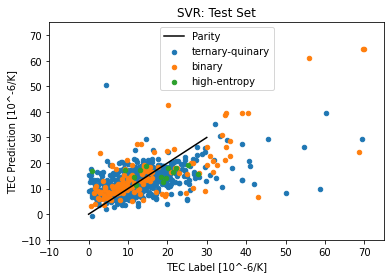

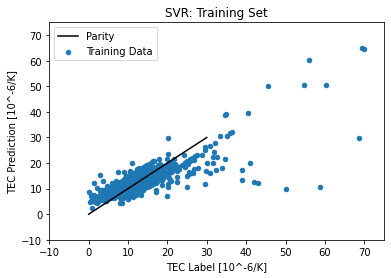

Correlation:  7.900906481894676e-05


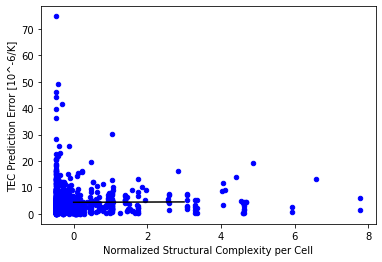

Correlation:  0.0019343566615299679


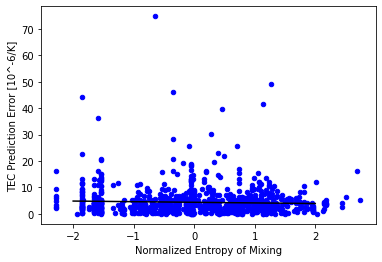

RandomForestRegressor
Selected Data: oxide, fluoride
Mean Training Set Score:  0.7815255552222279
Mean Test Set Score:  0.37106920643441305
ternary-quinary :  916 :  0.3191869566926494
binary :  144 :  0.5249408342742563
high-entropy :  14 :  0.26171329841237445


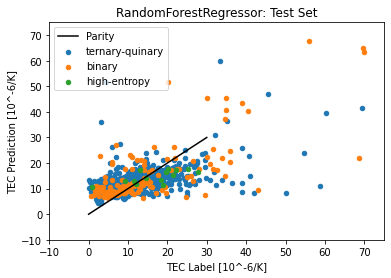

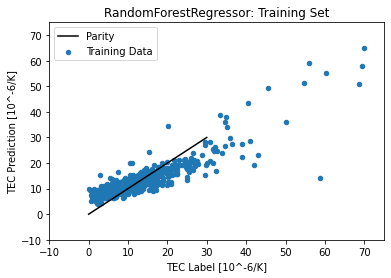

Correlation:  1.5108381540618332e-05


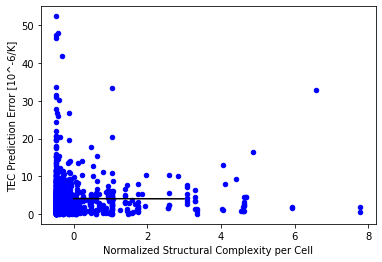

Correlation:  0.002928449682036094


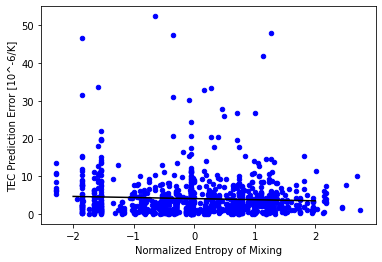

XGBRegressor
Selected Data: oxide, fluoride
Mean Training Set Score:  0.7928012471878105
Mean Test Set Score:  0.3860212562846822
ternary-quinary :  916 :  0.34955399029474377
binary :  144 :  0.49944209885211965
high-entropy :  14 :  0.2442400701301327


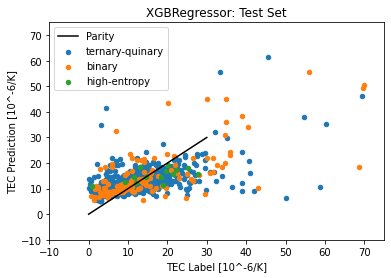

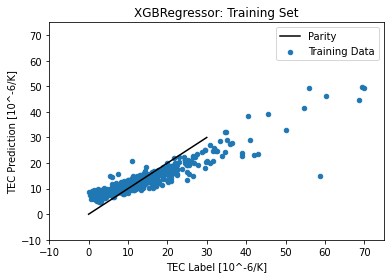

Correlation:  0.00011783162006950842


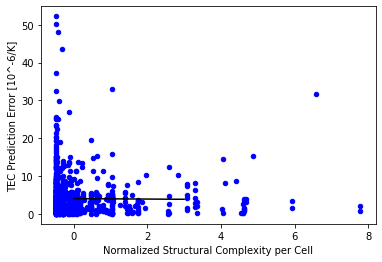

Correlation:  0.0040302854529963295


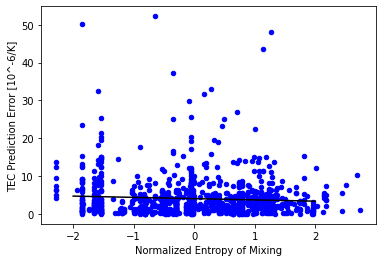

SVR
Selected Data: oxide, fluoride
Mean Training Set Score:  0.6553536843576837
Mean Test Set Score:  0.3504553554899238
cubic :  396 :  0.5101346006281262
orthorhombic :  215 :  0.18303836839508203
tetragonal :  176 :  0.15425551508075042
misc :  287 :  0.2838266556092732


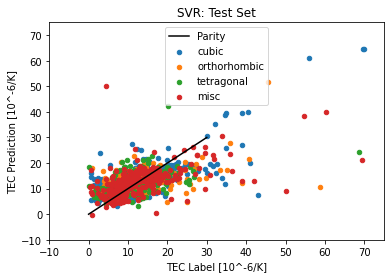

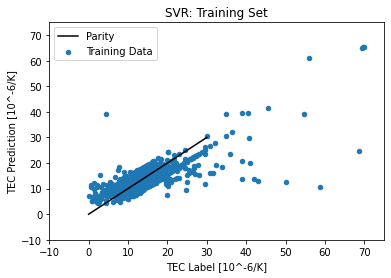

Correlation:  1.542645811736243e-05


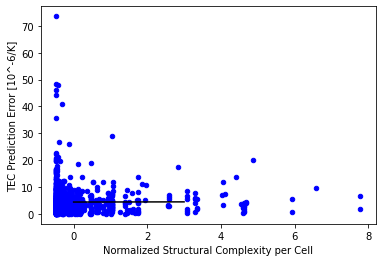

Correlation:  0.0024346595145605665


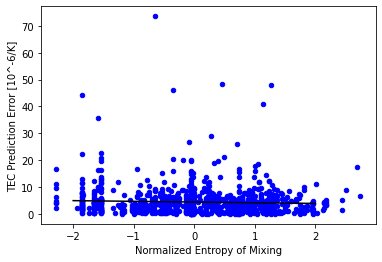

RandomForestRegressor
Selected Data: oxide, fluoride
Mean Training Set Score:  0.7802555029003515
Mean Test Set Score:  0.36392907581152
cubic :  396 :  0.5508588837572899
orthorhombic :  215 :  0.22893042161678945
tetragonal :  176 :  0.18744648592093427
misc :  287 :  0.27399944294412093


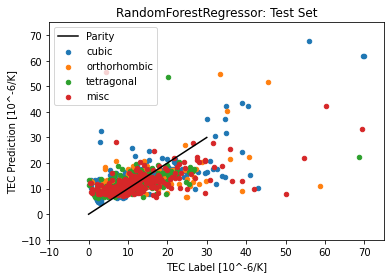

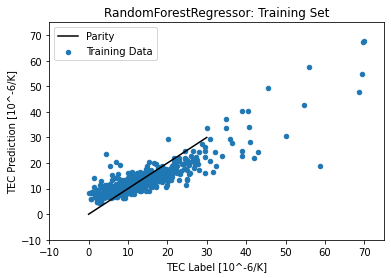

Correlation:  0.000157299424221935


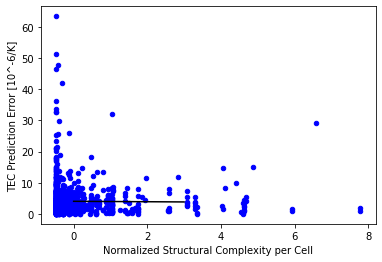

Correlation:  0.0029441276598834998


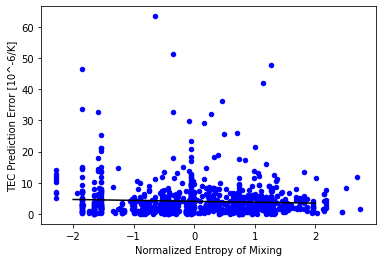

XGBRegressor
Selected Data: oxide, fluoride
Mean Training Set Score:  0.7929549330039396
Mean Test Set Score:  0.3819991512775121
cubic :  396 :  0.5588365530938114
orthorhombic :  215 :  0.2154328235413715
tetragonal :  176 :  0.2015687903718656
misc :  287 :  0.3031609944915513


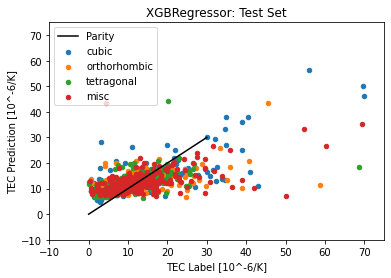

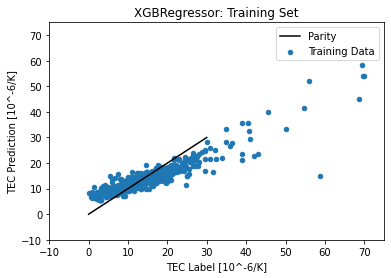

Correlation:  0.00022770043103892412


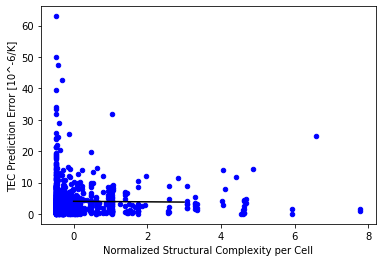

Correlation:  0.004322003380499928


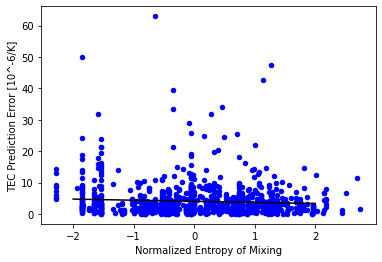

SVR
Selected Data: oxide, fluoride
Mean Training Set Score:  0.6588516382027899
Mean Test Set Score:  0.3247026229716116
Fm-3m :  170 :  0.5364026194785556
Pnma :  111 :  0.13853761033000522
Pm-3m :  105 :  0.3379165589950789
misc :  688 :  0.20103871995530043


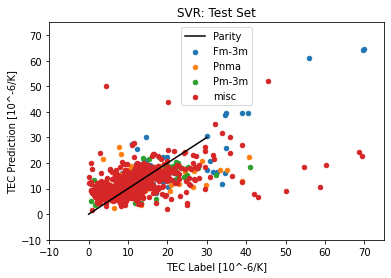

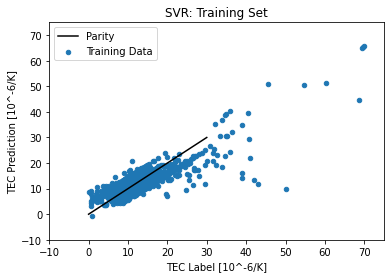

Correlation:  0.00027222910389057553


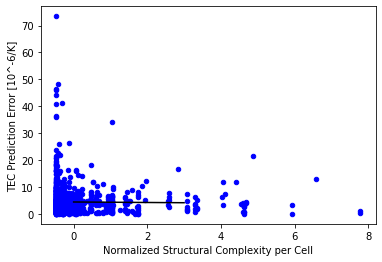

Correlation:  0.0020335799923940634


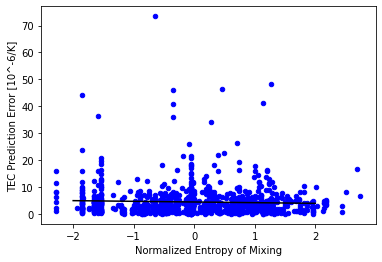

RandomForestRegressor
Selected Data: oxide, fluoride
Mean Training Set Score:  0.7771914550865302
Mean Test Set Score:  0.34018932082090225
Fm-3m :  170 :  0.586101732499349
Pnma :  111 :  0.32485160284838055
Pm-3m :  105 :  0.2430672715767449
misc :  688 :  0.2035465174868576


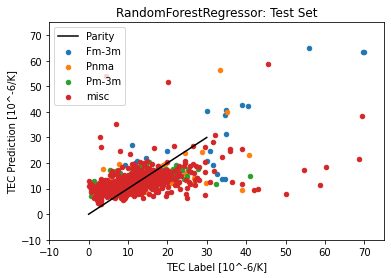

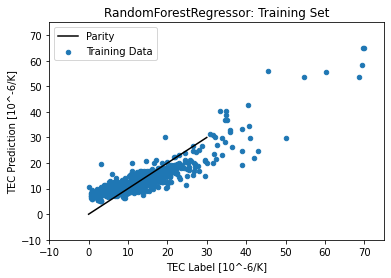

Correlation:  0.0007276841645587062


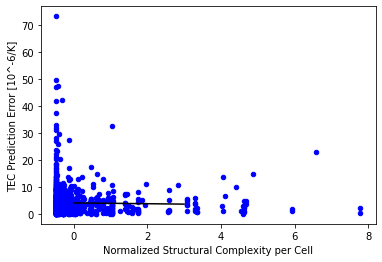

Correlation:  0.0034257721806333352


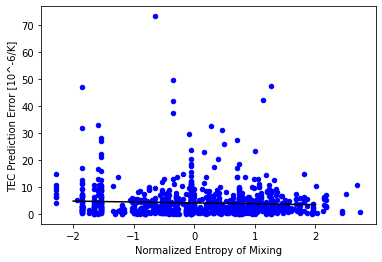

XGBRegressor
Selected Data: oxide, fluoride
Mean Training Set Score:  0.7949411727904998
Mean Test Set Score:  0.29056061390378757
Fm-3m :  170 :  0.5306954522852092
Pnma :  111 :  0.3267332630691122
Pm-3m :  105 :  0.31336920166979976
misc :  688 :  0.10623925488707875


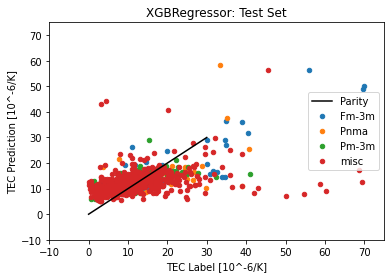

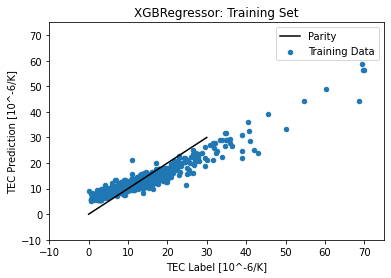

Correlation:  0.0002288612651446531


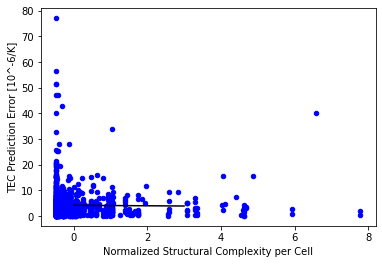

Correlation:  0.0044000248231998995


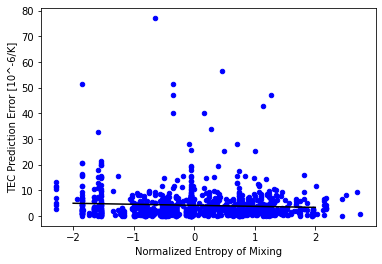

In [134]:
best_C, best_depth, best_nest = param_optimize(model_trainer)
model_trainer.add_models([SVR(C=best_C, epsilon=0.5), RandomForestRegressor(max_depth=best_depth), XGBRegressor(n_estimators=best_nest, max_depth=best_depth, eta=0.01)])
model_trainer.train_all_models(["class"], [[0,1]], "composition", 3)
model_trainer.train_all_models(["class"], [[0,1]], "system", 3)
model_trainer.train_all_models(["class"], [[0,1]], "group", 3)

Just Oxides (dont bother re-optimizing params)

SVR
Selected Data: oxide
Mean Training Set Score:  0.4654094353977067
Mean Test Set Score:  0.22919670335943598
ternary-quinary :  884 :  0.21027885786376843
binary :  119 :  0.26133029059867874
high-entropy :  14 :  0.08145373757723429


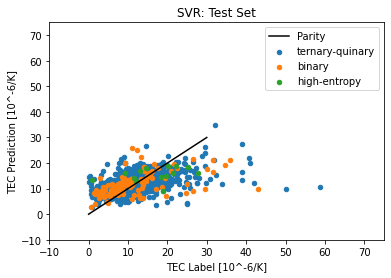

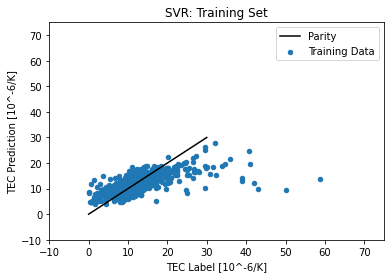

RandomForestRegressor
Selected Data: oxide
Mean Training Set Score:  0.7510539675586457
Mean Test Set Score:  0.2948208980390038
ternary-quinary :  884 :  0.2908442572635971
binary :  119 :  0.24731198719760517
high-entropy :  14 :  0.16626492053117048


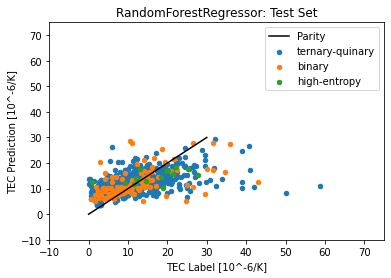

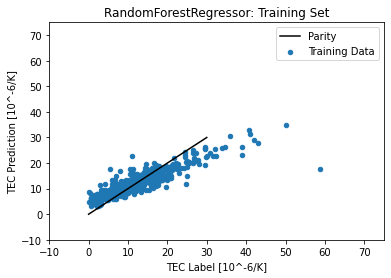

XGBRegressor
Selected Data: oxide
Mean Training Set Score:  0.8022319349824993
Mean Test Set Score:  0.2725987489889977
ternary-quinary :  884 :  0.26283865359941616
binary :  119 :  0.26732546491861886
high-entropy :  14 :  0.16943777986227093


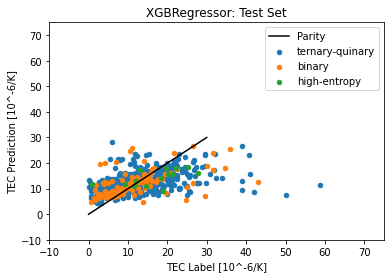

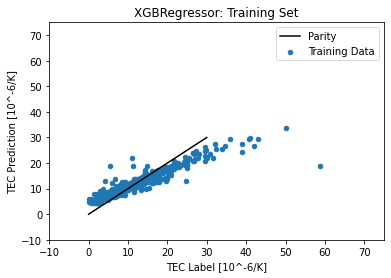

In [45]:
model_trainer.train_all_models(["class"], [[0]], "composition", 3)

Intrinsic Feature Importance

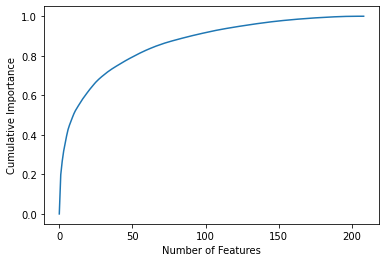

density :  0.1984047258701644
packing fraction :  0.0685650993476669
site CovalentRadius_atom1_mean :  0.05162689330247632
max packing efficiency :  0.038936076547955785
G4_0.005_4.0_-1.0_atom2_mean :  0.0373845361076822
site Electronegativity_atom1_mean :  0.03221100019784883
entropy of mixing :  0.022810794001187303
temperature_mean :  0.019711250022216704
AGNI eta=1.88e+00_atom2_mean :  0.019166993815437898
AGNI eta=1.23e+00_atom1_min :  0.01830776619762428
G4_0.005_4.0_-1.0_atom2_max :  0.015194457019025363
bond frac_std :  0.012628957813287527
temperature_max :  0.01190555864479589
temperature_min :  0.011873359078293143


In [53]:
trained_model = model_trainer.model_train(RandomForestRegressor(max_depth=6), return_model = True, show_plots=False)
feat_importance = trained_model.feature_importances_.copy()
feat_import_tot = []
sorted_feat_import = np.flip(np.sort(feat_importance))
for k in range(len(feat_importance)):
    feat_import_tot.append(sum(sorted_feat_import[0:k]))
plt.plot(np.arange(len(feat_importance)),  feat_import_tot)
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.show()

# Print labels ranked by importance
importance_ranked, label_names_ranked = zip(*sorted(zip(feat_importance, combined_feat_labels)))
for i in range(1,15):
    print(label_names_ranked[-i], ": ", importance_ranked[-i])
# Threesh ~0.005 for 25 features

## Separate oxides by Measurement Type

XRD Only

In [48]:
model_trainer.clear_models()
model_trainer.index_selector(["class"], [[0]], "composition", 3, only_xrd=True) 
len(model_trainer.selected_idxs)

432

Optimum: C: 6.951927961775605 , Depth:  9 , Num Estimators:  114
SVR
Selected Data: XRD Data, oxide
Mean Training Set Score:  0.4726486127428341
Mean Test Set Score:  0.23218399770121198
ternary-quinary :  365 :  0.23969312103687845
binary :  64 :  0.06875500445311222
high-entropy :  3 :  -2.0505399972694316


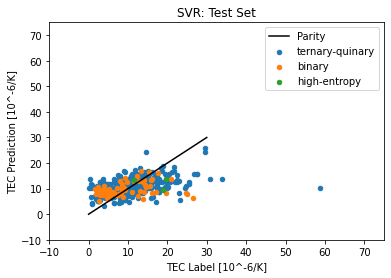

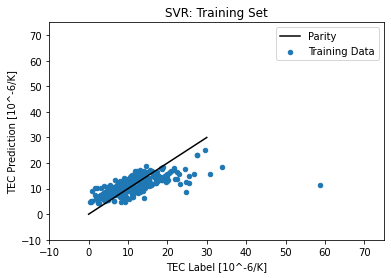

RandomForestRegressor
Selected Data: XRD Data, oxide
Mean Training Set Score:  0.7779517353229726
Mean Test Set Score:  0.22450918034463507
ternary-quinary :  365 :  0.23761743277567215
binary :  64 :  0.05834009165043452
high-entropy :  3 :  -0.8669626155007584


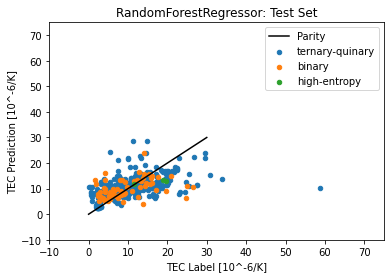

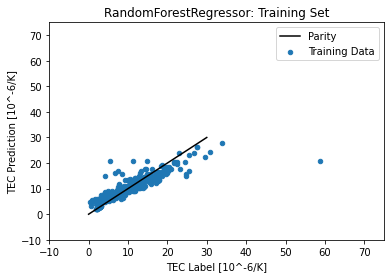

XGBRegressor
Selected Data: XRD Data, oxide
Mean Training Set Score:  0.6906590777832262
Mean Test Set Score:  0.19130499725698086
ternary-quinary :  365 :  0.20041998996153676
binary :  64 :  0.06908272527255488
high-entropy :  3 :  -2.0715980543478


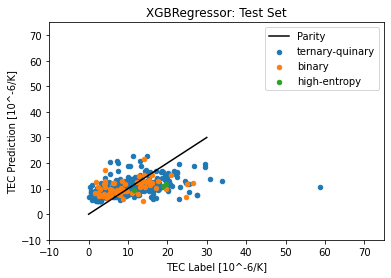

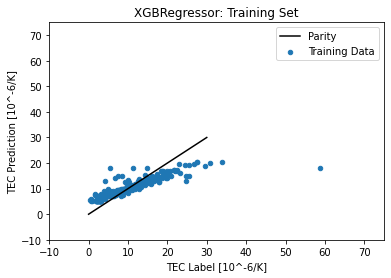

In [49]:
best_C, best_depth, best_nest = param_optimize(model_trainer)
model_trainer.add_models([SVR(C=best_C, epsilon=0.5), RandomForestRegressor(max_depth=best_depth), XGBRegressor(n_estimators=best_nest, max_depth=best_depth, eta=0.01)])
model_trainer.train_all_models(["class"], [[0]], "composition", 3, only_xrd = True)  

Dilatometer Only

In [50]:
model_trainer.clear_models()
model_trainer.index_selector(["class"], [[0]], "composition", 3, only_dil=True)
len(model_trainer.selected_idxs)

585

Optimum: C: 11.28837891684689 , Depth:  10 , Num Estimators:  174
SVR
Selected Data: Dilatometer Data, oxide
Mean Training Set Score:  0.44419700708969945
Mean Test Set Score:  0.1614647218713844
ternary-quinary :  519 :  0.20941430998421395
binary :  55 :  -0.04025918597949363
high-entropy :  11 :  0.1933612683330076


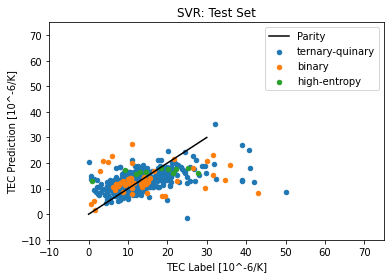

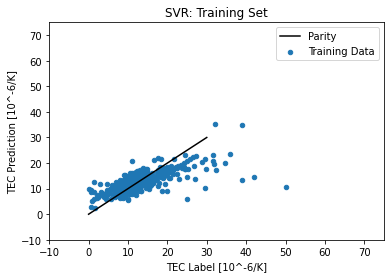

RandomForestRegressor
Selected Data: Dilatometer Data, oxide
Mean Training Set Score:  0.8537222313324502
Mean Test Set Score:  0.2014567686484153
ternary-quinary :  519 :  0.23914569664325136
binary :  55 :  0.06286943824416513
high-entropy :  11 :  0.1885708802228696


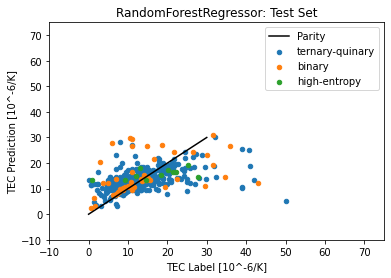

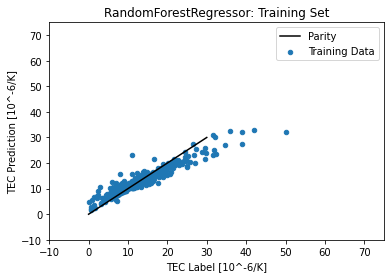

XGBRegressor
Selected Data: Dilatometer Data, oxide
Mean Training Set Score:  0.8811089322682699
Mean Test Set Score:  0.10702092840391397
ternary-quinary :  519 :  0.13768618244038888
binary :  55 :  0.02949842936097935
high-entropy :  11 :  0.03082498791425703


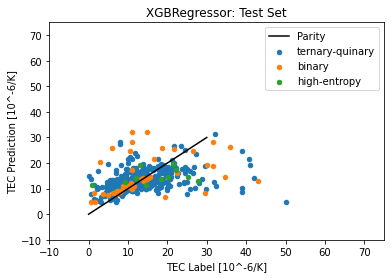

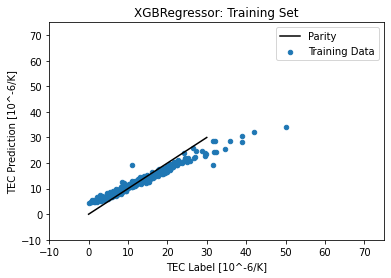

In [51]:
best_C, best_depth, best_nest = param_optimize(model_trainer)
model_trainer.add_models([SVR(C=best_C, epsilon=0.5), RandomForestRegressor(max_depth=best_depth), XGBRegressor(n_estimators=best_nest, max_depth=best_depth, eta=0.01)])
model_trainer.train_all_models(["class"], [[0]], "composition", 3, only_dil = True)  

## Control family: Crystal System 
Only Cubic, Ortho, and Tetragonal

In [22]:
model_trainer.clear_models()
model_trainer.index_selector(["system"], [[0, 1, 2]], "composition", 3) 
len(model_trainer.selected_idxs)

787

Optimum: C: 6.951927961775605 , Depth:  8 , Num Estimators:  174
SVR
Selected Data: cubic, orthorhombic, tetragonal
Mean Training Set Score:  0.5796084782085693
Mean Test Set Score:  0.38315037901080384
ternary-quinary :  671 :  0.24468700523938436
binary :  105 :  0.5907489669546117
high-entropy :  11 :  -0.056258590649908014


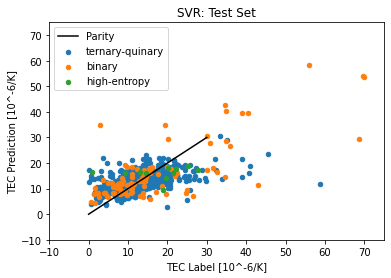

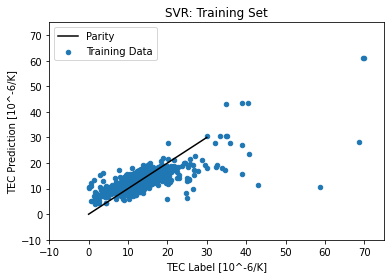

RandomForestRegressor
Selected Data: cubic, orthorhombic, tetragonal
Mean Training Set Score:  0.8152651148395081
Mean Test Set Score:  0.45832048406783665
ternary-quinary :  671 :  0.37737228848293536
binary :  105 :  0.5856972054444403
high-entropy :  11 :  0.13687635973829915


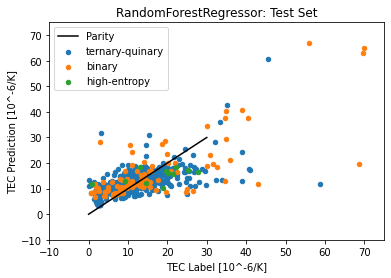

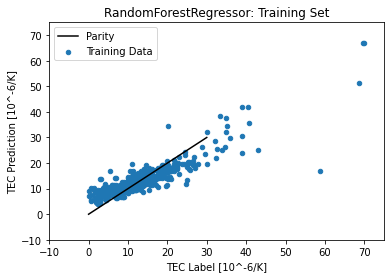

XGBRegressor
Selected Data: cubic, orthorhombic, tetragonal
Mean Training Set Score:  0.8091924269706409
Mean Test Set Score:  0.4417806304417898
ternary-quinary :  671 :  0.3487416321299188
binary :  105 :  0.546612414628487
high-entropy :  11 :  -0.036871312427601444


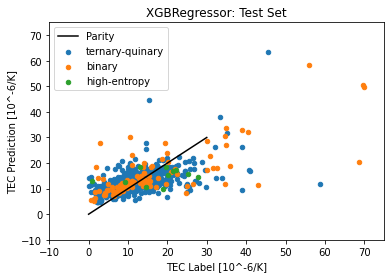

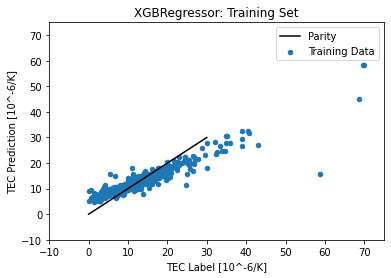

In [23]:
best_C, best_depth, best_nest = param_optimize(model_trainer)
model_trainer.add_models([SVR(C=best_C, epsilon=0.5), RandomForestRegressor(max_depth=best_depth), XGBRegressor(n_estimators=best_nest, max_depth=best_depth, eta=0.01)])
model_trainer.train_all_models(["system"], [[0, 1, 2]], "composition", 3) 

## Control structure: Space Group
Only spinels

In [13]:
model_trainer.clear_models()
model_trainer.index_selector(["group"], [[0]], "composition", 3) 
len(model_trainer.selected_idxs)

170

In [17]:
trained_model = model_trainer.model_train(RandomForestRegressor(max_depth=6), return_model = True, show_plots=False)
feat_importance = trained_model.feature_importances_.copy()
# Print labels ranked by importance
importance_ranked, label_names_ranked = zip(*sorted(zip(feat_importance, combined_feat_labels)))
for i in range(1,15):
    print(label_names_ranked[-i], ": ", int(1000*importance_ranked[-i])/1000)

jml_log_vpa :  0.201
site Electronegativity_atom1_mean :  0.059
density :  0.045
temperature :  0.043
temperature_min :  0.036
site AtomicWeight_atom1_mean :  0.034
site CovalentRadius_atom2_mean :  0.033
temperature_max :  0.032
temperature_mean :  0.028
site Number_atom1_mean :  0.021
G2_20.0_atom1_min :  0.021
packing fraction :  0.018
site CovalentRadius_atom1_mean :  0.015
G4_0.005_1.0_1.0_atom1_min :  0.015


Optimum: C: 885.8667904100823 , Depth:  9 , Num Estimators:  268
SVR
Selected Data: Fm-3m
Mean Training Set Score:  0.9130266970185005
Mean Test Set Score:  0.18994396656851734
ternary-quinary :  123 :  -0.42262239818194924
binary :  47 :  0.8357153145972139


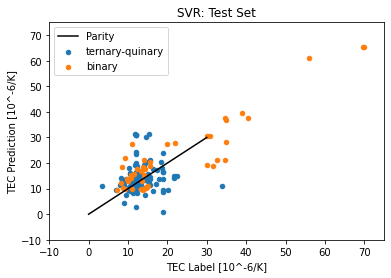

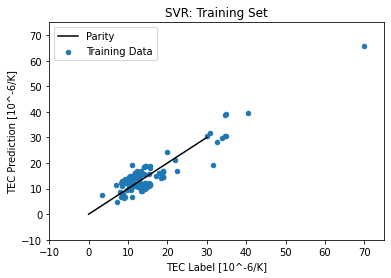

RandomForestRegressor
Selected Data: Fm-3m
Mean Training Set Score:  0.9377430650253356
Mean Test Set Score:  0.5539543234597748
ternary-quinary :  123 :  0.3309679820026644
binary :  47 :  0.8395065026784064


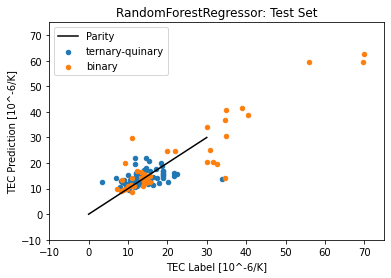

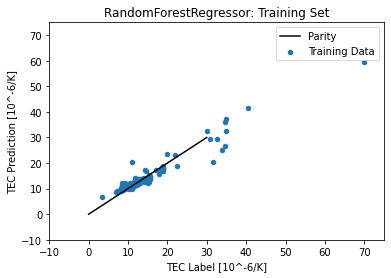

XGBRegressor
Selected Data: Fm-3m
Mean Training Set Score:  0.9495123994693377
Mean Test Set Score:  0.5814686812638394
ternary-quinary :  123 :  0.3916590829788056
binary :  47 :  0.8433164750497628


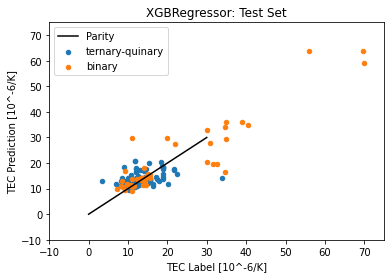

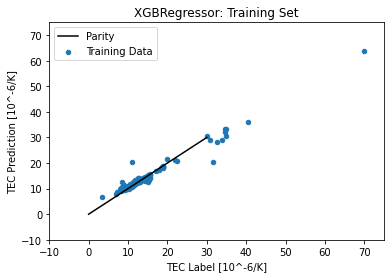

In [25]:
best_C, best_depth, best_nest = param_optimize(model_trainer)
model_trainer.add_models([SVR(C=best_C, epsilon=0.5), RandomForestRegressor(max_depth=best_depth), XGBRegressor(n_estimators=best_nest, max_depth=best_depth, eta=0.01)])
model_trainer.train_all_models(["group"], [[0]], "composition", 3) 

Only perovskites

In [26]:
model_trainer.clear_models()
model_trainer.index_selector(["group"], [[1]], "composition", 3) 
len(model_trainer.selected_idxs)

111

Optimum: C: 6.951927961775605 , Depth:  9 , Num Estimators:  114
SVR
Selected Data: Pnma
Mean Training Set Score:  0.6545720642218551
Mean Test Set Score:  0.30539036996370894
ternary-quinary :  106 :  0.29467094848073716
binary :  3 :  -0.9504032769327948
high-entropy :  2 :  -2.0156571362027735


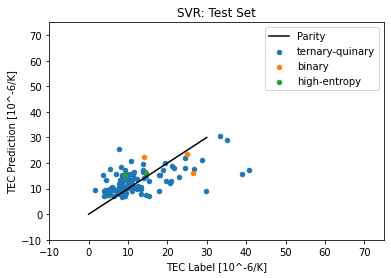

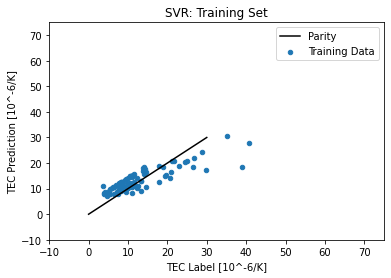

RandomForestRegressor
Selected Data: Pnma
Mean Training Set Score:  0.9056767928383855
Mean Test Set Score:  0.34446062499807123
ternary-quinary :  106 :  0.30478630513337557
binary :  3 :  -1.1958190935347894
high-entropy :  2 :  0.491178167011312


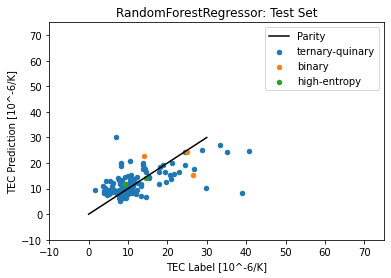

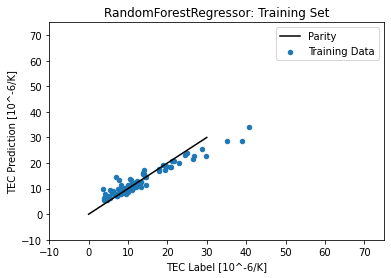

XGBRegressor
Selected Data: Pnma
Mean Training Set Score:  0.7933632799432483
Mean Test Set Score:  0.20482683811880903
ternary-quinary :  106 :  0.1908157019442741
binary :  3 :  -1.47627533414961
high-entropy :  2 :  -0.4983422228629091


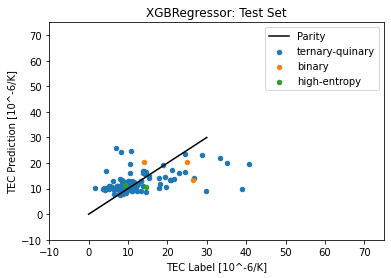

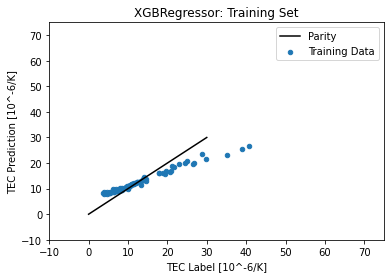

In [27]:
best_C, best_depth, best_nest = param_optimize(model_trainer)
model_trainer.add_models([SVR(C=best_C, epsilon=0.5), RandomForestRegressor(max_depth=best_depth), XGBRegressor(n_estimators=best_nest, max_depth=best_depth, eta=0.01)])
model_trainer.train_all_models(["group"], [[1]], "composition", 3) 

## Control Composition: Complexity
Only binary

In [18]:
model_trainer.clear_models()
model_trainer.index_selector(["composition"], [[1]], "system", 3) 
len(model_trainer.selected_idxs)

144

In [19]:
trained_model = model_trainer.model_train(RandomForestRegressor(max_depth=6), return_model = True, show_plots=False)
feat_importance = trained_model.feature_importances_.copy()
# Print labels ranked by importance
importance_ranked, label_names_ranked = zip(*sorted(zip(feat_importance, combined_feat_labels)))
for i in range(1,15):
    print(label_names_ranked[-i], ": ", int(1000*importance_ranked[-i])/1000)

site CovalentRadius_atom1_min :  0.071
packing fraction :  0.062
G4_0.005_4.0_-1.0_atom2_min :  0.058
temperature_mean :  0.053
temperature_max :  0.043
temperature_min :  0.034
site Electronegativity_atom1_max :  0.032
AGNI eta=1.23e+00_atom1_std :  0.03
density :  0.029
temperature :  0.027
jml_log_vpa :  0.021
site Number_atom2_mean :  0.02
G2_20.0_atom1_std :  0.02
site AtomicWeight_atom2_mean :  0.02


Optimum: C: 18.329807108324356 , Depth:  8 , Num Estimators:  174
SVR
Selected Data: binary
Mean Training Set Score:  0.7886465746293851
Mean Test Set Score:  0.5972676930991793
cubic :  66 :  0.714940271805124
orthorhombic :  10 :  0.454746514044316
tetragonal :  29 :  0.2521315393297425
misc :  39 :  0.566632820132828


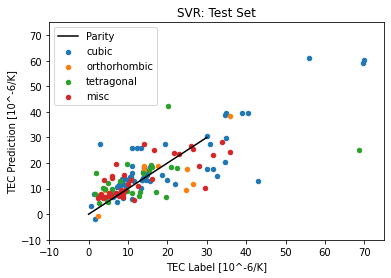

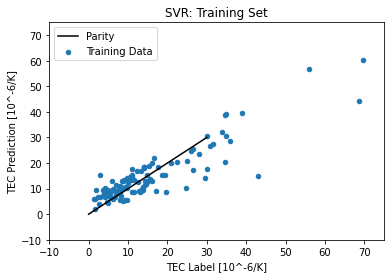

RandomForestRegressor
Selected Data: binary
Mean Training Set Score:  0.9207573458661091
Mean Test Set Score:  0.5163521970444469
cubic :  66 :  0.6342154978719534
orthorhombic :  10 :  0.38349702914801265
tetragonal :  29 :  0.20369991614733474
misc :  39 :  0.4173574059893821


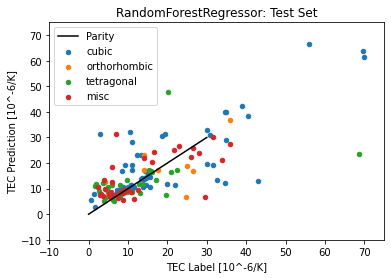

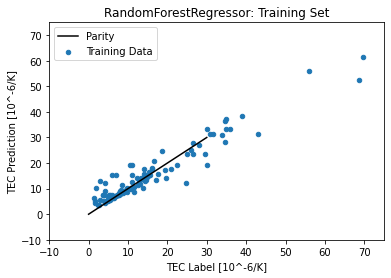

XGBRegressor
Selected Data: binary
Mean Training Set Score:  0.8879081383169425
Mean Test Set Score:  0.4870239850257659
cubic :  66 :  0.5959145107156327
orthorhombic :  10 :  0.25168084284186154
tetragonal :  29 :  0.083810418079595
misc :  39 :  0.5322574947906122


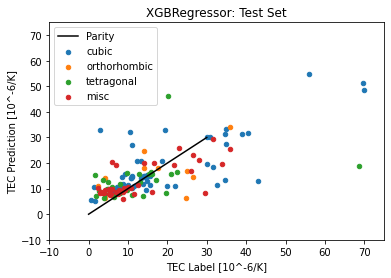

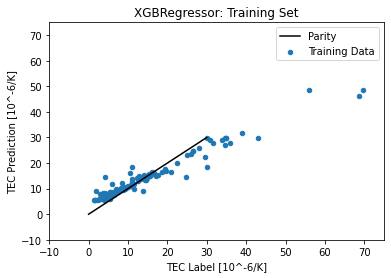

In [29]:
best_C, best_depth, best_nest = param_optimize(model_trainer)
model_trainer.add_models([SVR(C=best_C, epsilon=0.5), RandomForestRegressor(max_depth=best_depth), XGBRegressor(n_estimators=best_nest, max_depth=best_depth, eta=0.01)])
model_trainer.train_all_models(["composition"], [[1]], "system", 3) 

Only ternary-quinary

In [30]:
model_trainer.clear_models()
model_trainer.index_selector(["composition"], [[0]], "system", 3) 
len(model_trainer.selected_idxs)

916

Optimum: C: 11.28837891684689 , Depth:  9 , Num Estimators:  174
SVR
Selected Data: ternary-quinary
Mean Training Set Score:  0.5332623346832135
Mean Test Set Score:  0.24338606411319613
cubic :  323 :  0.28041363412198983
orthorhombic :  202 :  0.23321911821312968
tetragonal :  146 :  0.18783289199424336
misc :  245 :  0.2451725324196038


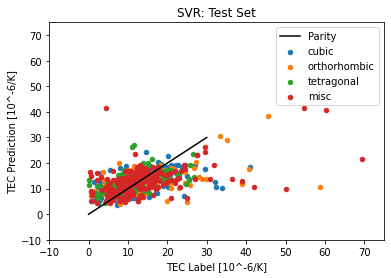

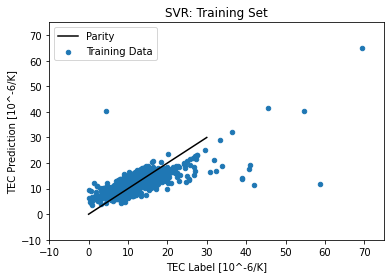

RandomForestRegressor
Selected Data: ternary-quinary
Mean Training Set Score:  0.8092622157952739
Mean Test Set Score:  0.2867155727183049
cubic :  323 :  0.41722637126090467
orthorhombic :  202 :  0.2228110573279598
tetragonal :  146 :  0.31471243293818296
misc :  245 :  0.2436266744645682


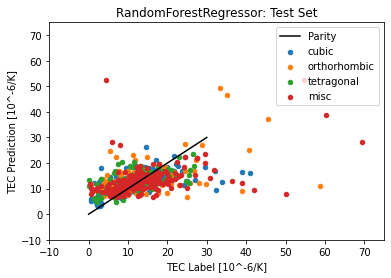

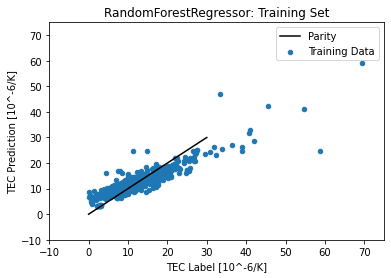

XGBRegressor
Selected Data: ternary-quinary
Mean Training Set Score:  0.8178027869112231
Mean Test Set Score:  0.2093273474963251
cubic :  323 :  0.3380067653831227
orthorhombic :  202 :  0.2431139102037818
tetragonal :  146 :  0.2499830334170572
misc :  245 :  0.09290002265848152


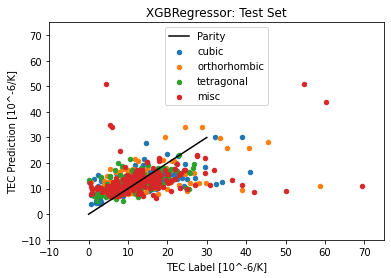

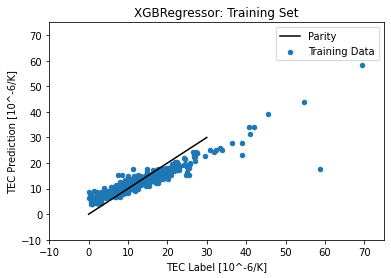

In [31]:
best_C, best_depth, best_nest = param_optimize(model_trainer)
model_trainer.add_models([SVR(C=best_C, epsilon=0.5), RandomForestRegressor(max_depth=best_depth), XGBRegressor(n_estimators=best_nest, max_depth=best_depth, eta=0.01)])
model_trainer.train_all_models(["composition"], [[0]], "system", 3) 

## Only Fluorides

In [22]:
model_trainer.clear_models()
model_trainer.index_selector(["class"], [[1]], "system", 3) 
len(model_trainer.selected_idxs)

57

In [24]:
trained_model = model_trainer.model_train(RandomForestRegressor(max_depth=3), return_model = True, show_plots=False)
feat_importance = trained_model.feature_importances_.copy()
# Print labels ranked by importance
importance_ranked, label_names_ranked = zip(*sorted(zip(feat_importance, combined_feat_labels)))
for i in range(1,15):
    print(label_names_ranked[-i], ": ", int(1000*importance_ranked[-i])/1000)

site Electronegativity_diff_min :  0.168
site Electronegativity_atom1_min :  0.124
site CovalentRadius_atom1_mean :  0.084
density :  0.064
temperature_mean :  0.055
site Electronegativity_atom1_mean :  0.052
G2_4.0_atom1_std :  0.049
AGNI eta=2.89e+00_atom1_std :  0.044
packing fraction :  0.03
temperature_max :  0.021
temperature_min :  0.02
temperature :  0.019
site AtomicWeight_diff_max :  0.019
AGNI eta=4.43e+00_atom1_std :  0.015


Optimum: C: 2.636650898730358 , Depth:  2 , Num Estimators:  48
SVR
Selected Data: fluoride
Mean Training Set Score:  0.5100937014119825
Mean Test Set Score:  0.42780876304083365
cubic :  29 :  0.36216643020625394
orthorhombic :  4 :  -0.5245966088737193
tetragonal :  13 :  0.3148338748850166
misc :  11 :  -0.015529025272125851


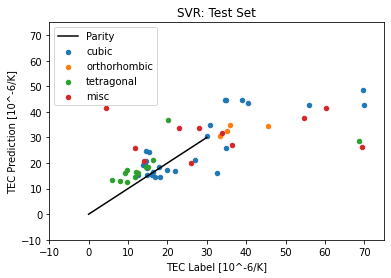

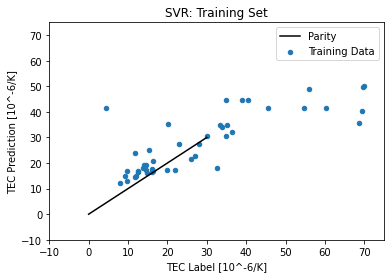

RandomForestRegressor
Selected Data: fluoride
Mean Training Set Score:  0.7617460494312474
Mean Test Set Score:  0.4295656429032264
cubic :  29 :  0.4100073662584375
orthorhombic :  4 :  -0.07411181954639234
tetragonal :  13 :  -0.12815991549830774
misc :  11 :  0.2751109266055678


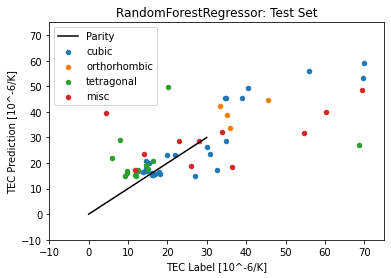

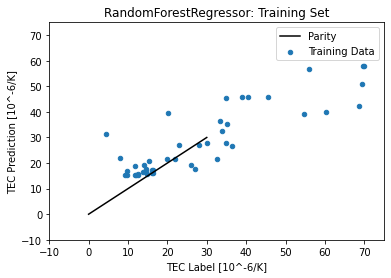

XGBRegressor
Selected Data: fluoride
Mean Training Set Score:  0.4206460921989869
Mean Test Set Score:  0.13142174535532777
cubic :  29 :  0.21955962743627677
orthorhombic :  4 :  -0.13883669205177274
tetragonal :  13 :  -0.43790411895195924
misc :  11 :  0.05661265732090848


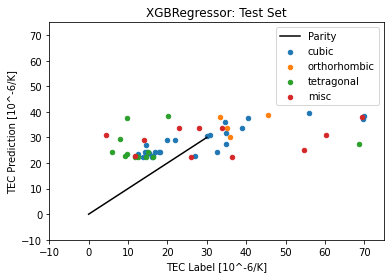

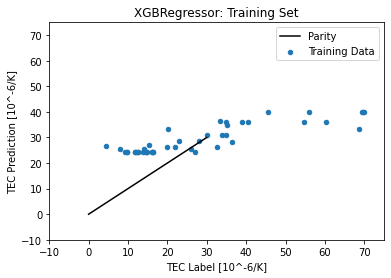

In [33]:
best_C, best_depth, best_nest = param_optimize(model_trainer)
model_trainer.add_models([SVR(C=best_C, epsilon=0.5), RandomForestRegressor(max_depth=best_depth), XGBRegressor(n_estimators=best_nest, max_depth=best_depth, eta=0.01)])
model_trainer.train_all_models(["class"], [[1]], "system", 3) 

## REFERENCE

SVR
Selected Data: oxide
Mean Training Set Score:  0.09132449975922545
Mean Test Set Score:  0.06707920472837128
ternary-quinary :  782 :  0.08582225158622858
binary :  112 :  0.0030500583251077407
high-entropy :  9 :  -2.674947928986954


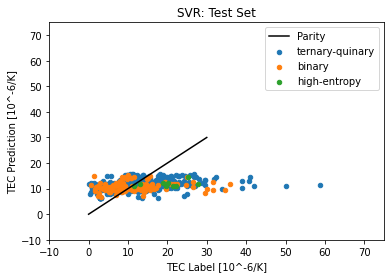

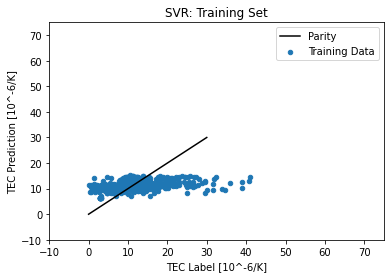

RandomForestRegressor
Selected Data: oxide
Mean Training Set Score:  0.7881669095341909
Mean Test Set Score:  0.2618328243929323
ternary-quinary :  782 :  0.22552215319165747
binary :  112 :  0.3161151066602489
high-entropy :  9 :  -0.3747538692838286


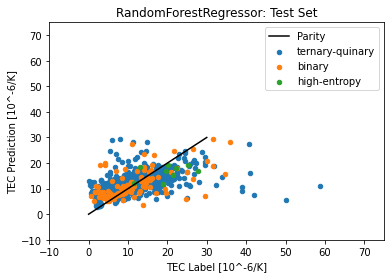

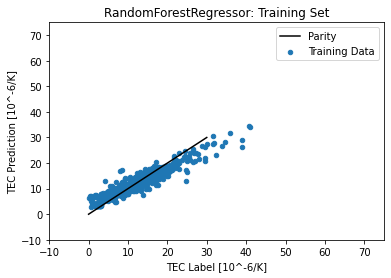

XGBRegressor
Selected Data: oxide
Mean Training Set Score:  0.8822964166434584
Mean Test Set Score:  0.2385106651706667
ternary-quinary :  782 :  0.2096831936820449
binary :  112 :  0.23273395136486486
high-entropy :  9 :  -0.38664707181294533


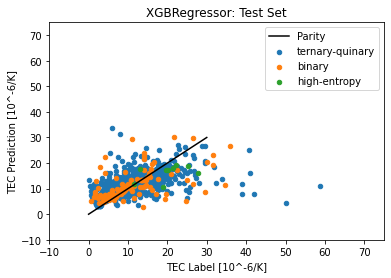

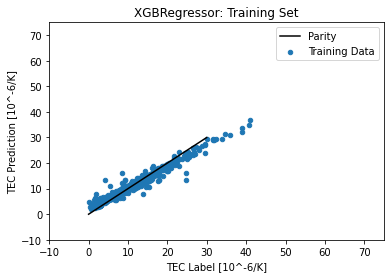

SVR
Selected Data: oxide
Mean Training Set Score:  0.0913614184686344
Mean Test Set Score:  0.06571220710633952
cubic :  325 :  0.07465615634435063
orthorhombic :  189 :  0.0677320706631167
tetragonal :  149 :  0.11431750763071757
trigonal :  118 :  -0.05915860601087952
misc :  122 :  0.046634325397648446


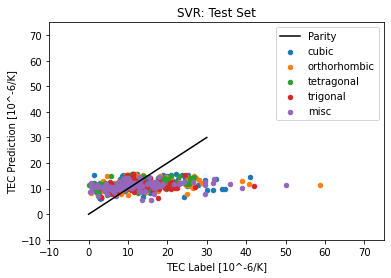

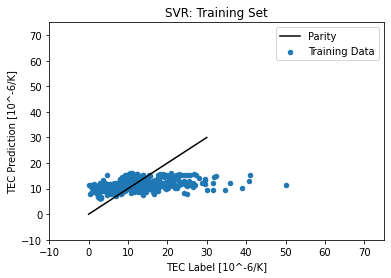

RandomForestRegressor
Selected Data: oxide
Mean Training Set Score:  0.787007191656403
Mean Test Set Score:  0.27971664328652535
cubic :  325 :  0.43437497778362466
orthorhombic :  189 :  0.04146033217400158
tetragonal :  149 :  0.4045335737360307
trigonal :  118 :  0.11028056530194463
misc :  122 :  0.2771384813491342


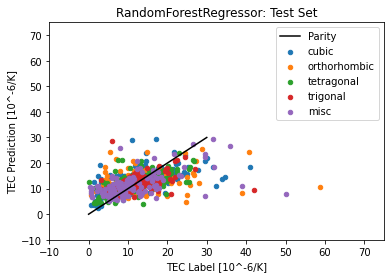

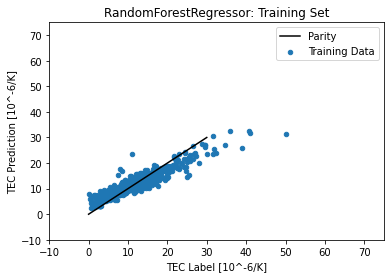

In [ ]:
# oxide/fluoride (2): "class" 
# crystal system (~6): "system"
# num_elements (3): "composition"
# space group (10+): "group"

# Segment oxides by composition
model_trainer.train_all_models(["class"], [[0]], "composition", 3)

# Segment oxides by crystal system
model_trainer.train_all_models(["class"], [[0]], "system", 4)

# Segment oxides by space group
model_trainer.train_all_models(["class"], [[0]], "group", 4)

# Segment fluorides by space group
model_trainer.train_all_models(["class"], [[1]], "system", 5)


# Segment cubic oxides by composition
model_trainer.train_all_models(["system", "class"], [[0], [0]], "composition", 3)

# Segment orthorhombic oxides by composition
model_trainer.train_all_models(["system", "class"], [[1], [0]], "composition", 3)

# Segment spinels oxides by composition
model_trainer.train_all_models(["group", "class"], [[0], [0]], "composition", 3)

# Segment perovskites oxides by composition
model_trainer.train_all_models(["group", "class"], [[1], [0]], "composition", 3)

# Segment binary oxides by system
model_trainer.train_all_models(["composition", "class"], [[1], [0]], "system", 5)

# Segment complex oxides by system
model_trainer.train_all_models(["composition", "class"], [[0,2], [0]], "system", 5)

In [11]:
model_trainer.clear_models()
model_trainer.add_models([SVR(C=100, epsilon=0.5, kernel='rbf'), RandomForestRegressor(max_depth=8), XGBRegressor(n_estimators=300, max_depth=8, eta=0.01)])

# Test dil only data
model_trainer.train_all_models(["class"], [[0]], "composition", 3, only_dil=True)
# Segment all by composition
model_trainer.train_all_models(["class"], [[0,1]], "composition", 3)
# oxide/fluoride (2): "class" 
# crystal system (~6): "system"
# num_elements (3): "composition"
# space group (10+): "group"

# Framework for sweeping params
model_trainer.index_selector(["class"], [[0]], "composition", 3)
param_vals = np.logspace(-1, 0, num=20) # CHANGE BASED ON PARAM
param_scores = []
for p in param_vals:
    param_scores.append( model_trainer.model_train(SVR(C=100, epsilon=0.5), show_plots=False)) # REPLACE MODEL 
plt.semilogx(param_vals, param_scores)
plt.xlabel("Parameter")
plt.ylabel("Test Set Score")
plt.show()